In [1]:
from EMsolver.solver import EMsolver
import numpy as np
import math
import os
import cupy
from numba import cuda
import ray
from EMsolver.region_distance import signal_indicator
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# start ray server
ray.init(ignore_reinit_error=True)

2021-04-04 21:54:30,012	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '210.45.78.32',
 'raylet_ip_address': '210.45.78.32',
 'redis_address': '210.45.78.32:6379',
 'object_store_address': '/tmp/ray/session_2021-04-04_21-54-29_498029_1511783/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-04_21-54-29_498029_1511783/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-04-04_21-54-29_498029_1511783',
 'metrics_export_port': 50402,
 'node_id': 'ae84d6eda2fecef3ed45885f5067571b884818bd4d85a4fedfaa4a74'}

In [2]:
def areal_position(i, d, left_boundary):
    return i*d + d/2 + left_boundary

# generate sinusodial sources of rho and J
def generate_rho_J(time, dx, dy, dz, x_left_boundary, y_left_boundary, z_left_boundary, \
                   x_grid_size, y_grid_size, z_grid_size, total_spatial_grid_size):    
    rho, Jx, Jy, Jz = (np.empty(total_spatial_grid_size, dtype=np.float32) for _ in range(4))
    for i_spatial in range(total_spatial_grid_size):
        iz = i_spatial%z_grid_size
        iz_rest = i_spatial//z_grid_size
        iy = iz_rest%y_grid_size
        iy_rest = iz_rest//y_grid_size
        ix = iy_rest%x_grid_size
        x, y, z = areal_position(ix, dx, x_left_boundary), areal_position(iy, dy, y_left_boundary), areal_position(iz, dz, z_left_boundary)
        Jx[i_spatial] = math.sin(x+y+z)*math.sin(time)
        Jy[i_spatial] = Jx[i_spatial]
        Jz[i_spatial] = Jx[i_spatial]
        rho[i_spatial] = 3*(math.cos(time)-1)*math.cos(x+y+z)
    return Jx, Jy, Jz, rho

In [3]:
# define the length of the sources
# rho_GPU and Jx_GPU are of shape [len_time_snapshots, total_grid_size]
len_time_snapshots = 208

# the regions are seperated as the source region and the observation region
x_grid_size_o, y_grid_size_o, z_grid_size_o = 5,5,5
x_grid_size_s, y_grid_size_s, z_grid_size_s = 5,5,5
dt = 0.05
i_GPU = '0'

# the infinitesimals of the regions
# here the source region and observational region are overlap
dx_o, dy_o, dz_o, x_left_boundary_o, y_left_boundary_o, z_left_boundary_o = \
                       6/x_grid_size_o, 6/y_grid_size_o, 6/z_grid_size_o, -3, -3, -3
dx_s, dy_s, dz_s, x_left_boundary_s, y_left_boundary_s, z_left_boundary_s = \
                       6/x_grid_size_s, 6/y_grid_size_s, 6/z_grid_size_s, -3, -3, -3

# load the remote server
f = EMsolver.remote(len_time_snapshots, i_GPU, \
                    x_grid_size_o, y_grid_size_o, z_grid_size_o, \
                    x_grid_size_s, y_grid_size_s, z_grid_size_s, \
                    dx_o, dy_o, dz_o, x_left_boundary_o, y_left_boundary_o, z_left_boundary_o, \
                    dx_s, dy_s, dz_s, x_left_boundary_s, y_left_boundary_s, z_left_boundary_s, \
                    dt)

# toy model of constant sources
rho= np.ones(x_grid_size_s*y_grid_size_s*z_grid_size_s, dtype=np.float32)
Jx, Jy, Jz = (np.ones(x_grid_size_s*y_grid_size_s*z_grid_size_s, dtype=np.float32) for _ in range(3))
Ex, Ey, Bx, By = (np.zeros(x_grid_size_s*y_grid_size_s*z_grid_size_s, dtype=np.float32) for _ in range(4))

Ex_list, Ey_list, Ez_list, Bx_list, By_list, Bz_list= [], [], [], [], [], []

start = timer()
for time in range(410):
  
    # updata new rho and J 
    f.update_rho_J.remote(rho, Jx, Jy, Jz)

    retarded_time = signal_indicator(dx_o, dy_o, dz_o, x_left_boundary_o, y_left_boundary_o, z_left_boundary_o, \
                                     dx_s, dy_s, dz_s, x_left_boundary_s, y_left_boundary_s, z_left_boundary_s, \
                                     x_grid_size_o, y_grid_size_o, z_grid_size_o, \
                                     x_grid_size_s, y_grid_size_s, z_grid_size_s)
    if time*dt >= retarded_time:
        Ex, Ey, _, Bx, By, _ = ray.get(f.Jefimenko_solver.remote())
        
        if time%1==0:
            Ex_list.append(Ex.reshape([x_grid_size_o, y_grid_size_o, z_grid_size_o])[:,:,2])
            Ey_list.append(Ey.reshape([x_grid_size_o, y_grid_size_o, z_grid_size_o])[:,:,2])
            Bx_list.append(Bx.reshape([x_grid_size_o, y_grid_size_o, z_grid_size_o])[:,:,2])
            By_list.append(By.reshape([x_grid_size_o, y_grid_size_o, z_grid_size_o])[:,:,2])
end = timer()
print('evaluation time:',end-start)     

evaluation time: 5.648948241025209


In [4]:
np.transpose([Ex_list[102],Ey_list[102]])

array([[[-6.2666547e-01, -6.2666541e-01],
        [-2.8636035e-01, -8.1468844e-01],
        [ 5.1226419e-09, -8.6783046e-01],
        [ 2.8636032e-01, -8.1468838e-01],
        [ 6.2666529e-01, -6.2666535e-01]],

       [[-8.1468850e-01, -2.8636038e-01],
        [-3.7928158e-01, -3.7928161e-01],
        [-1.2601699e-07, -4.1571468e-01],
        [ 3.7928143e-01, -3.7928161e-01],
        [ 8.1468815e-01, -2.8636038e-01]],

       [[-8.6783051e-01, -1.3446934e-08],
        [-4.1571471e-01, -2.9711321e-08],
        [-3.9956607e-08, -1.3318869e-08],
        [ 4.1571465e-01, -9.2207548e-09],
        [ 8.6783028e-01, -6.1471699e-09]],

       [[-8.1468838e-01,  2.8636035e-01],
        [-3.7928164e-01,  3.7928155e-01],
        [ 7.2741514e-08,  4.1571465e-01],
        [ 3.7928167e-01,  3.7928161e-01],
        [ 8.1468827e-01,  2.8636044e-01]],

       [[-6.2666523e-01,  6.2666529e-01],
        [-2.8636044e-01,  8.1468844e-01],
        [-6.3520758e-08,  8.6783040e-01],
        [ 2.8636050e-01,  

you should get

      [[[-6.2666547e-01, -6.2666541e-01],
        [-2.8636035e-01, -8.1468844e-01],
        [ 5.1226419e-09, -8.6783046e-01],
        [ 2.8636032e-01, -8.1468838e-01],
        [ 6.2666529e-01, -6.2666535e-01]],

       [[-8.1468850e-01, -2.8636038e-01],
        [-3.7928158e-01, -3.7928161e-01],
        [-1.2601699e-07, -4.1571468e-01],
        [ 3.7928143e-01, -3.7928161e-01],
        [ 8.1468815e-01, -2.8636038e-01]],

       [[-8.6783051e-01, -1.3446934e-08],
        [-4.1571471e-01, -2.9711321e-08],
        [-3.9956607e-08, -1.3318869e-08],
        [ 4.1571465e-01, -9.2207548e-09],
        [ 8.6783028e-01, -6.1471699e-09]],

       [[-8.1468838e-01,  2.8636035e-01],
        [-3.7928164e-01,  3.7928155e-01],
        [ 7.2741514e-08,  4.1571465e-01],
        [ 3.7928167e-01,  3.7928161e-01],
        [ 8.1468827e-01,  2.8636044e-01]],

       [[-6.2666523e-01,  6.2666529e-01],
        [-2.8636044e-01,  8.1468844e-01],
        [-6.3520758e-08,  8.6783040e-01],
        [ 2.8636050e-01,  8.1468838e-01],
        [ 6.2666541e-01,  6.2666535e-01]]]

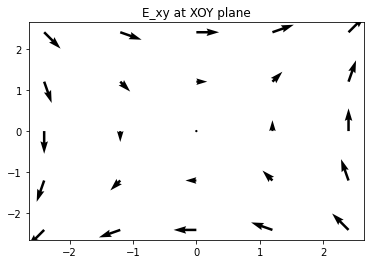

In [5]:
X = np.arange(-2.4, 3, 1.2)
Y = np.arange(-2.4, 3, 1.2)

fig, ax = plt.subplots()
q = ax.quiver(X, Y, Ex_list[102], Ey_list[102])
ax.set_title('E_xy at XOY plane')

plt.show()

In [6]:
# define the length of the sources
# rho_GPU and Jx_GPU are of shape [len_time_snapshots, total_grid_size]
len_time_snapshots = 420

# the regions are seperated as the source region and the observation region
x_grid_size_o, y_grid_size_o, z_grid_size_o = 5,5,5
x_grid_size_s, y_grid_size_s, z_grid_size_s = 5,5,5
dt = 0.05
i_GPU = '0'

# the infinitesimals of the regions
# the two regions are not overlap
dx_o, dy_o, dz_o, x_left_boundary_o, y_left_boundary_o, z_left_boundary_o = \
                                     6/x_grid_size_o, 6/y_grid_size_o, 6/z_grid_size_o, -3, -3, -3
dx_s, dy_s, dz_s, x_left_boundary_s, y_left_boundary_s, z_left_boundary_s = \
                                     6/x_grid_size_s, 6/y_grid_size_s, 6/z_grid_size_s, -3, -3, 10

# load the remote server
f = EMsolver.remote(len_time_snapshots, i_GPU, \
                    x_grid_size_o, y_grid_size_o, z_grid_size_o, \
                    x_grid_size_s, y_grid_size_s, z_grid_size_s, \
                    dx_o, dy_o, dz_o, x_left_boundary_o, y_left_boundary_o, z_left_boundary_o, \
                    dx_s, dy_s, dz_s, x_left_boundary_s, y_left_boundary_s, z_left_boundary_s, \
                    dt)

# toy model of constant sources
rho= np.ones(x_grid_size_s*y_grid_size_s*z_grid_size_s, dtype=np.float32)
Jx, Jy, Jz = (np.ones(x_grid_size_s*y_grid_size_s*z_grid_size_s, dtype=np.float32) for _ in range(3))
Ex, Ey, Bx, By = (np.zeros(x_grid_size_s*y_grid_size_s*z_grid_size_s, dtype=np.float32) for _ in range(4))

Ex_list, Ey_list, Ez_list, Bx_list, By_list, Bz_list= [], [], [], [], [], []

start = timer()
for time in range(410):

    # acquire new rho and J
    Jx, Jy, Jz, rho = generate_rho_J(time*dt, dx_s, dy_s, dz_s, x_left_boundary_s, y_left_boundary_s, z_left_boundary_s, \
                                     x_grid_size_s, y_grid_size_s, z_grid_size_s, x_grid_size_s*y_grid_size_s*z_grid_size_s)
    
    # updata new rho and J 
    f.update_rho_J.remote(rho, Jx, Jy, Jz)

    retarded_time = signal_indicator(dx_o, dy_o, dz_o, x_left_boundary_o, y_left_boundary_o, z_left_boundary_o, \
                                     dx_s, dy_s, dz_s, x_left_boundary_s, y_left_boundary_s, z_left_boundary_s, \
                                     x_grid_size_o, y_grid_size_o, z_grid_size_o, \
                                     x_grid_size_s, y_grid_size_s, z_grid_size_s)
    if time*dt >= retarded_time:
        Ex, Ey, _, Bx, By, _ = ray.get(f.Jefimenko_solver.remote())
        
        if time%1==0:
            Ex_list.append(Ex.reshape([x_grid_size_o, y_grid_size_o, z_grid_size_o])[:,:,2])
            Ey_list.append(Ey.reshape([x_grid_size_o, y_grid_size_o, z_grid_size_o])[:,:,2])
            Bx_list.append(Bx.reshape([x_grid_size_o, y_grid_size_o, z_grid_size_o])[:,:,2])
            By_list.append(By.reshape([x_grid_size_o, y_grid_size_o, z_grid_size_o])[:,:,2])
end = timer()
print('evaluation time:',end-start)     
            

evaluation time: 4.534827593713999


In [7]:
np.transpose([Ex_list[111],Ey_list[111]])

array([[[ 0.04846862,  0.04846862],
        [ 0.04448292,  0.03987582],
        [ 0.00884735,  0.00604565],
        [-0.01361285, -0.0092989 ],
        [-0.02270786, -0.01158025]],

       [[ 0.03987582,  0.04448293],
        [ 0.01391405,  0.01391406],
        [-0.00441413, -0.00811273],
        [-0.00819116, -0.00990828],
        [ 0.00527389,  0.0095917 ]],

       [[ 0.00604566,  0.00884734],
        [-0.00811272, -0.00441413],
        [ 0.00732641,  0.00732641],
        [ 0.0064563 ,  0.00361152],
        [ 0.01901778,  0.01854202]],

       [[-0.00929889, -0.01361285],
        [-0.00990828, -0.00819116],
        [ 0.00361151,  0.0064563 ],
        [ 0.0350694 ,  0.0350694 ],
        [ 0.01968484,  0.01864913]],

       [[-0.01158025, -0.02270786],
        [ 0.0095917 ,  0.00527389],
        [ 0.01854203,  0.01901778],
        [ 0.01864913,  0.01968484],
        [-0.01724102, -0.01724103]]], dtype=float32)

you should get

      [[[ 0.04846862,  0.04846862],
        [ 0.04448292,  0.03987582],
        [ 0.00884735,  0.00604565],
        [-0.01361285, -0.0092989 ],
        [-0.02270786, -0.01158025]],

       [[ 0.03987582,  0.04448293],
        [ 0.01391405,  0.01391406],
        [-0.00441413, -0.00811273],
        [-0.00819116, -0.00990828],
        [ 0.00527389,  0.0095917 ]],

       [[ 0.00604566,  0.00884734],
        [-0.00811272, -0.00441413],
        [ 0.00732641,  0.00732641],
        [ 0.0064563 ,  0.00361152],
        [ 0.01901778,  0.01854202]],

       [[-0.00929889, -0.01361285],
        [-0.00990828, -0.00819116],
        [ 0.00361151,  0.0064563 ],
        [ 0.0350694 ,  0.0350694 ],
        [ 0.01968484,  0.01864913]],

       [[-0.01158025, -0.02270786],
        [ 0.0095917 ,  0.00527389],
        [ 0.01854203,  0.01901778],
        [ 0.01864913,  0.01968484],
        [-0.01724102, -0.01724103]]]

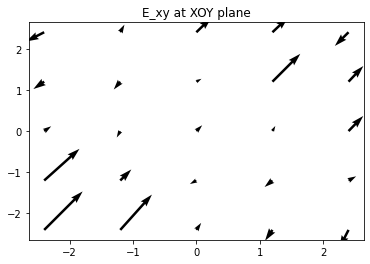

In [8]:
X = np.arange(-2.4, 3, 1.2)
Y = np.arange(-2.4, 3, 1.2)

fig, ax = plt.subplots()
q = ax.quiver(X, Y, Ex_list[111], Ey_list[111])
ax.set_title('E_xy at XOY plane')

plt.show()